In [2]:
df = sqlContext.read.format('csv').options(header='true', inferschema='true')\
    .load('../notas.csv')
df.rdd.take(3)

[Row(Alumno=1, Matematica=15, Lenguaje=16, Fisica=16, Estadistica=15, Filosofia=14),
 Row(Alumno=2, Matematica=17, Lenguaje=14, Fisica=15, Estadistica=16, Filosofia=16),
 Row(Alumno=3, Matematica=13, Lenguaje=15, Fisica=12, Estadistica=13, Filosofia=15)]

In [5]:
#Feature selection
df2=df.select('Matematica','Lenguaje','Fisica','Estadistica','Filosofia')
#df2.show()

In [7]:
# df2.groupBy("Matematica").count().show()

In [40]:

from pyspark.ml.feature import VectorAssembler
fea=['Matematica','Lenguaje','Fisica','Estadistica','Filosofia']
featureAssembler = VectorAssembler(inputCols=fea, outputCol="features")

#solo para mostrar
dfa = featureAssembler.transform(df2) # this will add to the table outputCol column with vectors.
dfa.show()


+----------+--------+------+-----------+---------+--------------------+
|Matematica|Lenguaje|Fisica|Estadistica|Filosofia|            features|
+----------+--------+------+-----------+---------+--------------------+
|        15|      16|    16|         15|       14|[15.0,16.0,16.0,1...|
|        17|      14|    15|         16|       16|[17.0,14.0,15.0,1...|
|        13|      15|    12|         13|       15|[13.0,15.0,12.0,1...|
|        18|      16|    17|         17|       15|[18.0,16.0,17.0,1...|
|        14|      13|    16|         15|       14|[14.0,13.0,16.0,1...|
|        18|      16|    17|         16|       15|[18.0,16.0,17.0,1...|
|        15|      14|    14|         14|       14|[15.0,14.0,14.0,1...|
|        16|      11|    12|         14|       12|[16.0,11.0,12.0,1...|
|        17|      16|    13|         15|       15|[17.0,16.0,13.0,1...|
|        18|      12|    14|         15|       13|[18.0,12.0,14.0,1...|
|        12|      13|    15|         13|       12|[12.0,13.0,15.

In [33]:
# from pyspark.ml import Pipeline

In [41]:
#3 distribucion de los datos

# set seed for reproducibility
(trainingData, testData) = df2.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 13
Test Dataset Count: 7


In [42]:
#4. Modelamiento (con un modelo ML)
# Fit Decision Tree Classification Model
from pyspark.ml.classification import DecisionTreeClassifier

# Instancia model
dTree = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')

In [43]:
from numpy import array
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import pandas as pd

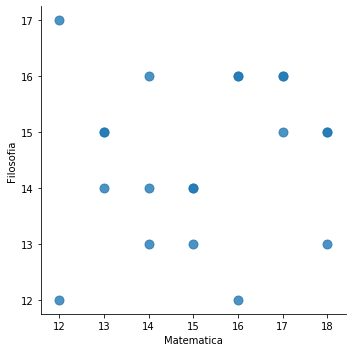

In [36]:
sns.lmplot(x='Matematica',y='Filosofia',data=df2.toPandas(),fit_reg=False,legend=True,scatter_kws={"s":80}) #,hue='Fisica'

In [19]:

# from pyspark.ml import Pipeline

In [44]:
#3 distribucion de los datos
# set seed for reproducibility
(trainingData, testData) = dfa.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 13
Test Dataset Count: 7


In [45]:
#4. Modelamiento (con un modelo ML)
# Fit KMans Model
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Instancia model
#dTree = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')
kmeans = KMeans().setK(3).setSeed(1)
model = kmeans.fit(trainingData.select('features')) # train kmeans model

In [47]:
# Shows the result.
centers = model.clusterCenters()
centers = np.array([ arr for arr in centers])
centers

array([[16.66666667, 14.33333333, 14.16666667, 15.5       , 14.83333333],
       [13.        , 16.        , 12.5       , 12.75      , 14.75      ],
       [13.66666667, 14.        , 15.66666667, 14.33333333, 13.33333333]])

In [48]:
import pandas as pd
centersdf = pd.DataFrame(data=centers, columns=fea)
centersdf_transposed = centersdf.T
centersdf_transposed.columns = pd.MultiIndex.from_arrays([['Cluster #']*len(centersdf_transposed.columns), centersdf_transposed.columns])
centersdf_transposed.index.names = ['Attribute']
centersdf_transposed

Cluster #                  
                     0      1          2
Attribute                               
Matematica   16.666667  13.00  13.666667
Lenguaje     14.333333  16.00  14.000000
Fisica       14.166667  12.50  15.666667
Estadistica  15.500000  12.75  14.333333
Filosofia    14.833333  14.75  13.333333

In [49]:

centers[:,0]

array([16.66666667, 13.        , 13.66666667])

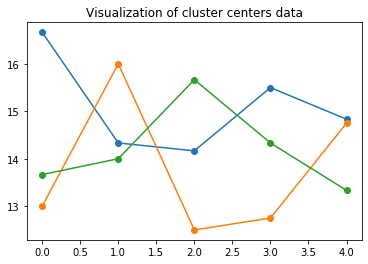

In [50]:
def plot(centers):
    for i,c in enumerate(centers):
        plt.plot(centers[i], '-o')
    plt.title('Visualization of cluster centers data');
    plt.show()
plot(centers)

In [51]:
# Evaluate clustering by computing Within Set Sum of Squared Errors.
wssse = model.computeCost(trainingData)
print("Within Set Sum of Squared Errors = "+ str(wssse))

Within Set Sum of Squared Errors = 99.00000000000045


In [52]:
cost = np.zeros(10)
for k in range(2,10):
    kmeansf = KMeans(k=k, seed=1)  # k clusters here
    modelf = kmeansf.fit(trainingData.select('features'))
    cost[k] = modelf.computeCost(trainingData) # requires Spark 2.0 or later

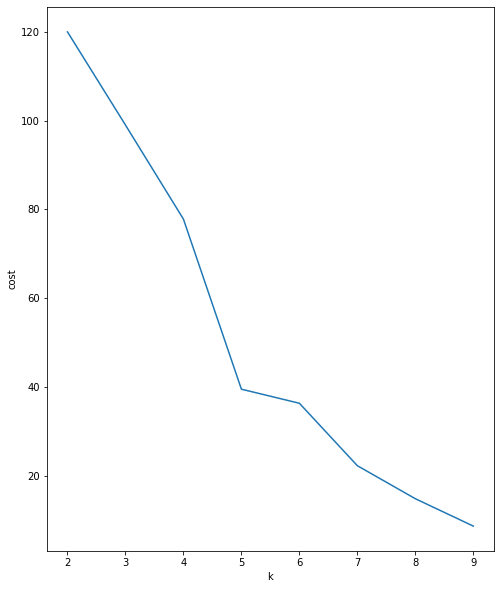

In [53]:
fig, ax = plt.subplots(1,1, figsize =(8,10))
ax.plot(range(2,10),cost[2:10])
ax.set_xlabel('k')
ax.set_ylabel('cost')
plt.show()